# Dataset (from Kaggle)

In [ ]:
! pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d awsaf49/brats2020-training-data

100% 6.74G/6.76G [01:11<00:00, 158MB/s]
100% 6.76G/6.76G [01:11<00:00, 101MB/s]


In [ ]:
import os
import csv
import random
import shutil
import zipfile

zip_file_path = '/content/brats2020-training-data.zip'

extract_dir = 'training_data/'

nested_dir = 'BraTS2020_training_data/content/data/'

# CSV file containing the list of 10k file names
random_files = 'random_files.csv'

os.makedirs(extract_dir, exist_ok=True)

file_names = []
with open(random_files, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        file_names.append(row[0])

# Extract only the specified files from the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_name in file_names:
        zip_ref.extract(nested_dir + file_name, extract_dir)

In [ ]:
import os

training_data_directory = '/content/training_data/'

files = os.listdir(training_data_directory)

for file in files:
    print(file)

BraTS2020_training_data


In [ ]:
import shutil

def delete_directory(path):
    try:
        shutil.rmtree(path)
        print(f"Deleted directory: {path}")
    except OSError as e:
        print(f"Error: {path} : {e.strerror}")

# Example usage
delete_directory('/content/training_data')


Deleted directory: /content/training_data


# MSR Augmentation Implementation

In [ ]:
import torchvision.transforms as transforms

Define augmentation parameters and transforms as required

In [ ]:
msr_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
])

In [ ]:
# augmented_image = msr_augmentation(img)

# SPN Augmentation Implementation

In [ ]:
import torch
import random

In [ ]:
class SPNAugmentation(object):
    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level

    # img - image tensor with shape (C, H, W).
    def __call__(self, img):
        patch_size = 4
        batch_size, C, H, W = img.shape
        num_patches_h = H
        num_patches_w = W

        for b in range(batch_size):
            for h in range(num_patches_h):
                for w in range(num_patches_w):
                    if np.random.rand() < self.noise_level:
                        y1 = h * patch_size
                        y2 = min(y1 + patch_size, H)
                        x1 = w * patch_size
                        x2 = min(x1 + patch_size, W)
                        patch = img[b, :, y1:y2, x1:x2]
                        shuffled_patch = patch[:, np.random.permutation(patch.shape[1]), :][:, :, np.random.permutation(patch.shape[2])]
                        img[b, :, y1:y2, x1:x2] = shuffled_patch

        return img

In [ ]:
spn = SPNAugmentation(noise_level=0.2)
# augmented_image = spn(img)

# Converting Image to C, H, W tensor

In [ ]:
from PIL import Image
import numpy as np
import torch
import h5py


In [ ]:
def convert_h5_to_tensor(path):
    with h5py.File(path, 'r') as file:
        image_array = np.array(file['image'])
        image_tensor = torch.from_numpy(image_array)
        image_tensor = image_tensor.permute(2, 0, 1)
        image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

# Applying the transforms

torch.Size([1, 3, 240, 240])


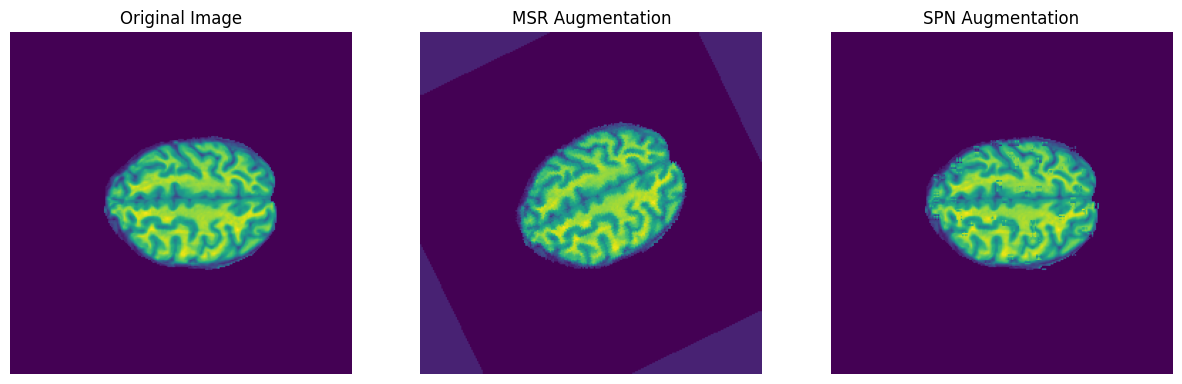

torch.Size([1, 3, 240, 240])


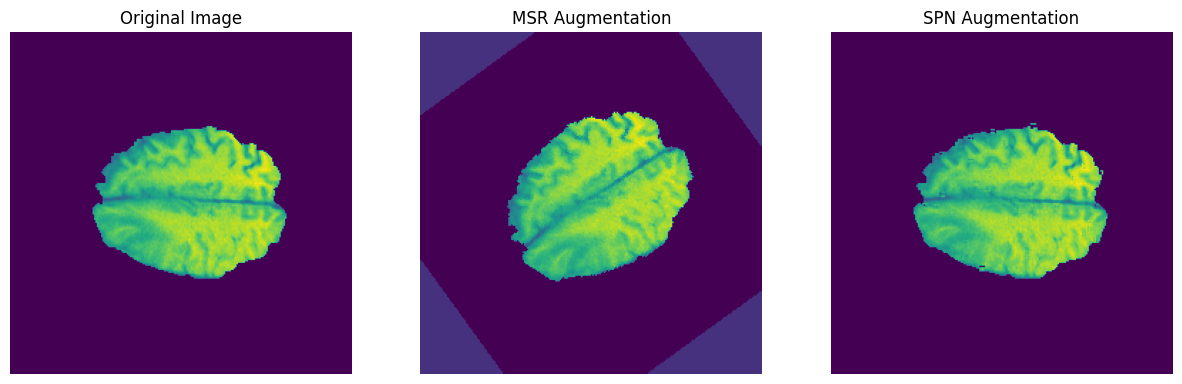

torch.Size([1, 3, 240, 240])


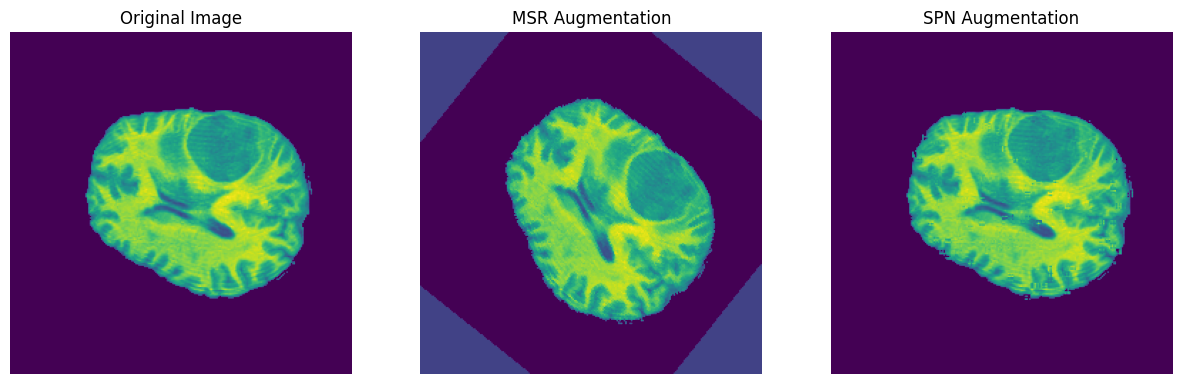

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import h5py

data_dir = '/content/data/BraTS2020_training_data/content/data/'

file_list = ['volume_156_slice_117.h5', 'volume_252_slice_115.h5', 'volume_365_slice_85.h5']

for file_name in file_list:
    file_path = data_dir + file_name
    original_image_tensor = convert_h5_to_tensor(file_path)

    # Convert 4-channel image to 3 channels
    selected_channels = [0, 1, 2]
    original_image_tensor = original_image_tensor[:, selected_channels, :, :]

    # Apply MSR augmentation
    transformed_image_msr = msr_augmentation(original_image_tensor.clone())

    # Apply SPN augmentation
    spn_augmentation = SPNAugmentation(noise_level=0.1)
    print(original_image_tensor.clone().shape)
    transformed_image_spn = spn_augmentation(original_image_tensor.clone())

    # Convert tensors to numpy arrays for display
    original_image = original_image_tensor.squeeze().permute(1, 2, 0).numpy()
    msr_image = transformed_image_msr.squeeze().permute(1, 2, 0).numpy()
    spn_image = transformed_image_spn.squeeze().permute(1, 2, 0).numpy()

    # Display original and augmented images
    displayed_channel = [1]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[:, :, displayed_channel])
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(msr_image[:, :, displayed_channel])
    plt.title('MSR Augmentation')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(spn_image[:, :, displayed_channel])
    plt.title('SPN Augmentation')
    plt.axis('off')

    plt.show()

Future Reference: https://www.kaggle.com/code/atharvabhogale/multi-model-brats

# Applying CNN based segmentation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import numpy as np
import h5py
import os
import torch.nn.functional as F


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
input_channels = 3  # how many channels for the images
num_classes = 2  # Assuming there are 2 classes: background and tumor

model = CNNModel(input_channels, num_classes)

# Applying Meta's Segment Anything Model (SAM)

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth # default model weights

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1rh9d_39
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1rh9d_39
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2024-02-29 08:54:12--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.111, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  50.8MB/s    in 49s     

2024-02-29 08:55:01 (49.9 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
from segment_anything import sam_model_registry
sam = sam_model_registry["vit_h"]("/content/sam_vit_h_4b8939.pth")

In [ ]:
tensor = convert_h5_to_tensor("/content/data/BraTS2020_training_data/content/data/volume_156_slice_117.h5")
tensor_normalized = (tensor - tensor.min()) / (tensor.max() - tensor.min())
# Convert the tensor to a PIL Image


In [ ]:
from segment_anything import SamPredictor, SamAutomaticMaskGenerator
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)
# print(tensor_normalized.squeeze(0, 1)[[0,1,2], :, :].shape)
masks = mask_generator.generate(tensor_normalized.squeeze(0, 1)[[0, 1, 2], :, :])

In [ ]:
print(len(masks))
print(masks[0].keys())

5
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

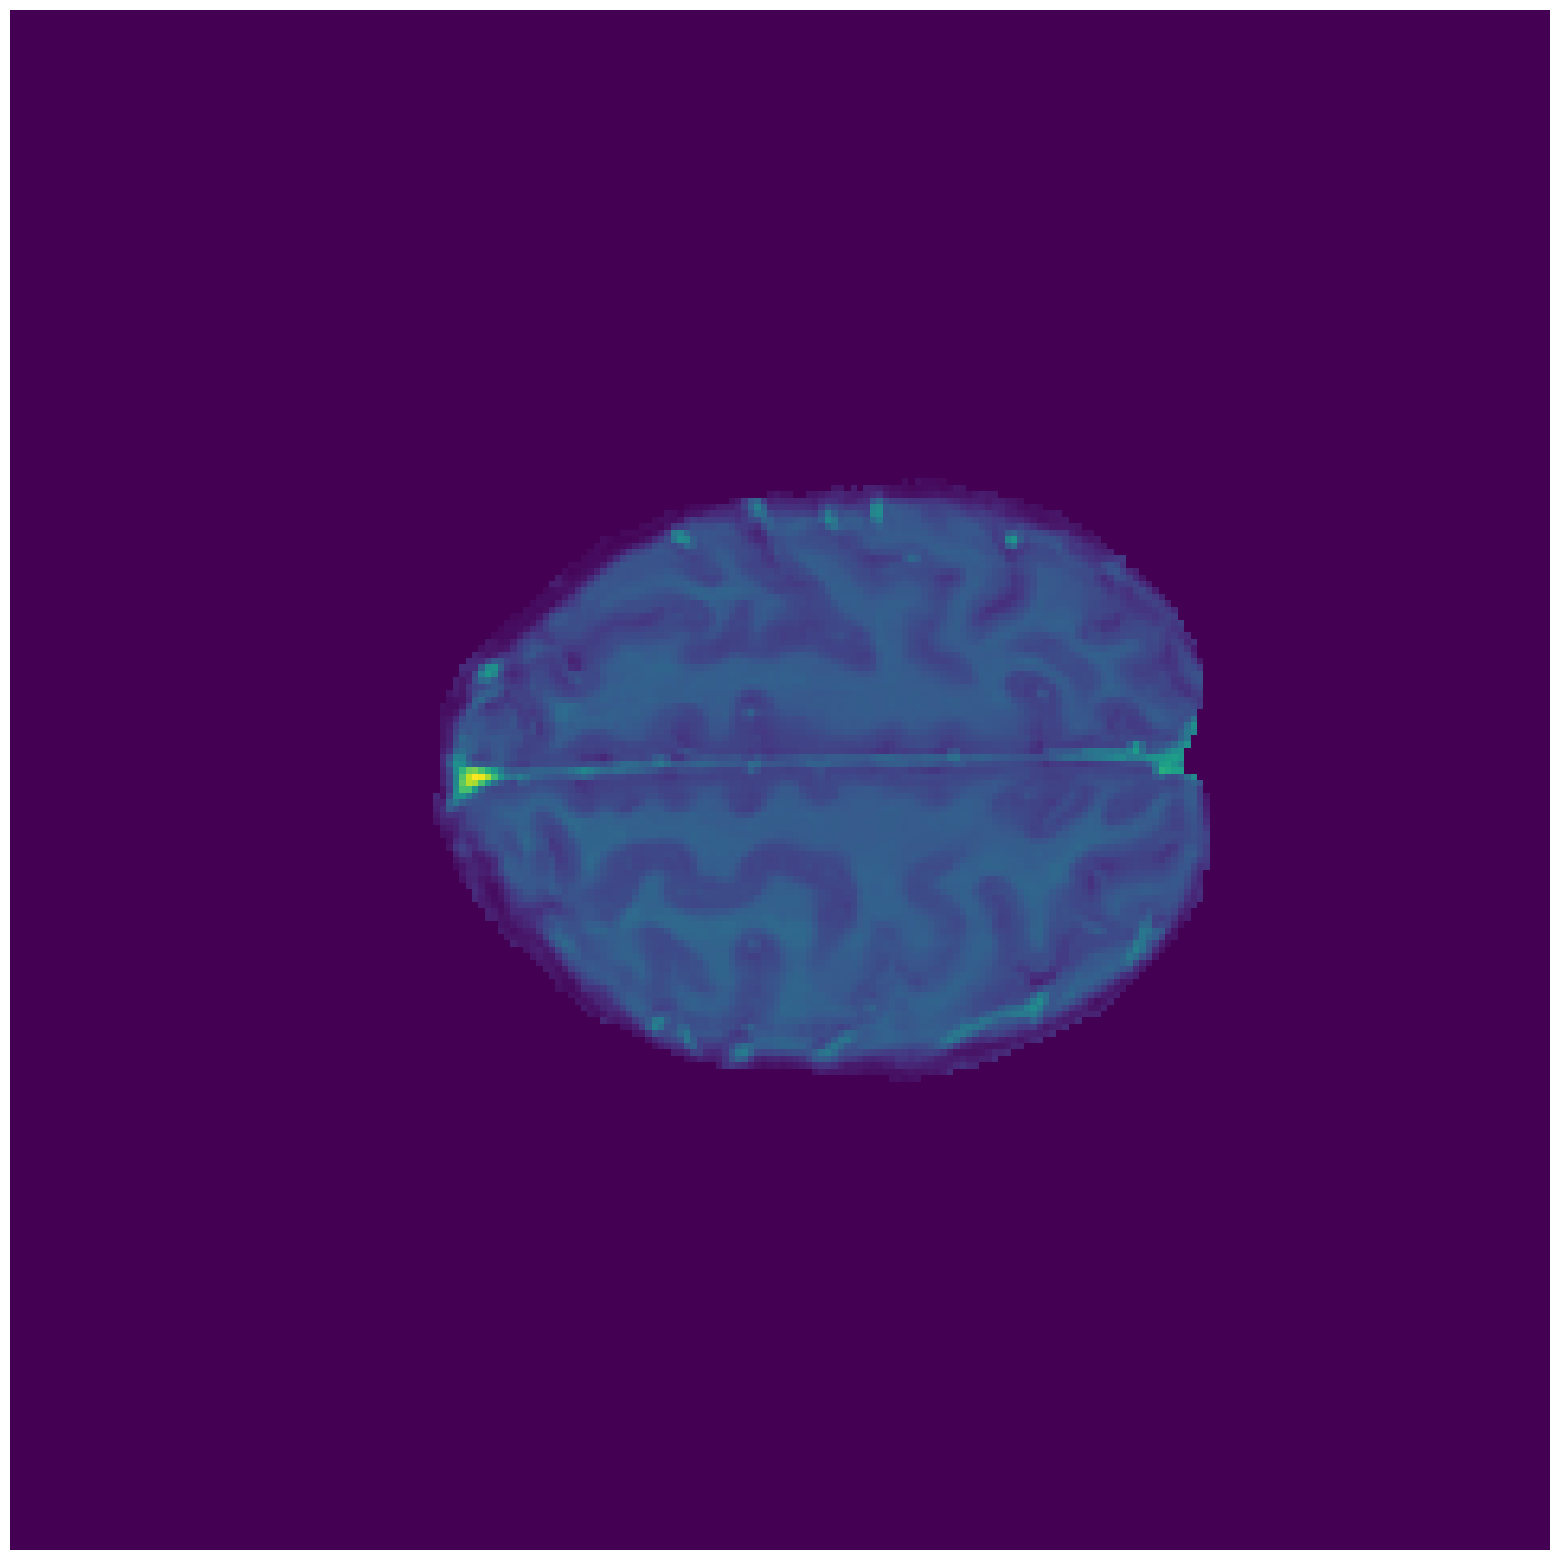

In [ ]:
tensor_to_image = transforms.ToPILImage()(tensor_normalized.squeeze(0)[[2], :, :])

plt.figure(figsize=(20,20))
plt.imshow(tensor_to_image)
# show_anns(masks)
plt.axis('off')
plt.show()

# TODO:

1. Use a pretrained U-NET model, read the paper.
2. Augment using smaller dataset.
3. Explain dataset stats.
4. design own Unet.

## U-Net

In [ ]:
import torch
import os
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import h5py

In [ ]:
#load the model
net = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/milesial/Pytorch-UNet/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale0.5_epoch2.pth" to /root/.cache/torch/hub/checkpoints/unet_carvana_scale0.5_epoch2.pth
100%|██████████| 118M/118M [00:00<00:00, 162MB/s]


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
# define dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = os.listdir(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.data_dir, img_name)
        with h5py.File(img_path, 'r') as f:
            image = f['data'][:]  # Assuming the image data is stored under 'data' dataset
        if self.transform:
            image = self.transform(image)
        return image, img_name

In [ ]:
# Define transformations and DataLoader
data_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL image
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [ ]:
data_dir = 'training_data/BraTS2020_training_data/content/data'  # Update with your training data directory

dataset = CustomDataset(data_dir=data_dir, transform=data_transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
num_images_to_show = 5
with torch.no_grad():
    for i, (images, img_names) in enumerate(dataloader):
        if i >= num_images_to_show:
            break
        images = images.to(device)
        outputs = net(images)
        output_mask = outputs.squeeze().cpu().detach().numpy()
        img_name = img_names[0]  # Assuming batch size is 1
        original_img = Image.fromarray(images[0].squeeze().cpu().numpy().transpose(1, 2, 0))  # Convert tensor to PIL image

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(output_mask, cmap='gray')
        plt.title('Segmentation Mask')
        plt.axis('off')

        plt.show()